In [40]:
!pip install tensorboardX

In [1]:
from sys import path
path.append("/home/ec2-user/SageMaker/data-science-development/utils")
path.append("/home/ec2-user/SageMaker/data-science-development/config")

import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

import os
import torch
import random
import json
import datetime
import time

from torch import nn
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

from datetime import datetime
from collections import defaultdict, Counter
from tqdm import tqdm 

tqdm.pandas()

import numpy.random as npr
import logging
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
from torch.autograd import Variable
from tensorboardX import SummaryWriter
from model.config_hyper_para import *
from data_prepro import *
from model.models import *
from torchdiffeq import odeint

import model.regular as regul
import math
import random
import matplotlib

In [2]:
skills = pd.read_csv("../../Data/skills_one-hot.csv").set_index("candidate_id")
skills.head()

,skill_1,skill_2,skill_3,skill_5,skill_6,skill_7,skill_8,skill_9,skill_12,skill_13,...,skill_3926,skill_3927,skill_3928,skill_3929,skill_3930,skill_3931,skill_3932,skill_3933,skill_3934,skill_3935
candidate_id,,,,,,,,,,,,,,,,,,,,,
84267,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84349,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84381,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84386,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84432,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
skills = dict(zip(skills.index, skills.values))

In [4]:
certs = pd.read_csv("../../Data/candidate_certificates_one-hot.csv").set_index("candidate_id")
certs.head()

,1,10,11,12,13,14,15,16,17,18,...,W4,W5,W7,W9,WB,WC,WD,WE,WF,ZW
candidate_id,,,,,,,,,,,,,,,,,,,,,
84603,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84867,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
85035,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
85102,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
85214,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
certs = dict(zip(certs.index, certs.values))

In [6]:
licenses = pd.read_csv("../../Data/licenses_one-hot.csv").set_index("candidate_id")
licenses.head()

,A,B,BE,C,CE,D,DE,G
candidate_id,,,,,,,,
84556,0,1,0,0,0,0,0,0
84612,0,0,0,0,0,0,0,1
84731,1,1,0,0,0,0,0,0
85437,0,1,0,0,0,0,0,0
85627,0,1,1,0,0,0,0,0


In [7]:
licenses = dict(zip(licenses.index, licenses.values))

In [8]:
languages = pd.read_csv("../../Data/languages_one-hot.csv").set_index("candidate_id")
languages.head()

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
candidate_id,,,,,,,,,,,,,,,,,,,,,
84267,0,0,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84349,0,0,1,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84381,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
84386,0,0,1,1,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
84432,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
languages = dict(zip(languages.index, languages.values))

In [10]:
addresses = pd.read_csv("../../Data/addresses_one-hot.csv").set_index("candidate_id")
addresses.head()

,0
candidate_id,
84556,90
84612,48
84731,3766
85437,3812
85627,1556


In [11]:
addresses = dict(zip(addresses.index, addresses.values))

In [12]:
w2v = json.load(open("../../Data/embeddings.json"))
# Convert to ints
w2v = {int(k):{int(k2):v2 for k2, v2 in v.items()} for k, v in w2v.items()}

In [13]:
df_pred = pd.read_csv("../../Data/df_pred_ext.csv").drop("Unnamed: 0", axis=1)

In [14]:
df_pred["time_between"] = (df_pred["time_between"] - df_pred["time_between"].mean()) / df_pred["time_between"].std()
df_pred["time_spent"] = (df_pred["time_spent"] - df_pred["time_spent"].mean()) / df_pred["time_spent"].std()

In [15]:
df_pred.head()

,candidate_id,job_order,time_between,time_spent,isco_functie_niveau,source,education,company_name,function_id,isco_code4
0,84556,0,-0.292887,-0.210459,2.0,0,0.0,324258,936,208
1,84556,1,-0.306568,-0.252626,1.0,0,0.0,324258,809,348
2,84556,2,-0.306568,-0.085012,2.0,0,0.0,329244,936,208
3,84556,3,0.799670,-0.370694,1.0,0,0.0,368140,1519,344
4,84556,4,-0.130664,-0.363314,1.0,0,0.0,419826,1519,344


In [16]:
len(df_pred["function_id"].unique()), len(df_pred["company_name"].unique())

(2989, 267934)

In [17]:
majority_class = df_pred["isco_code4"].mode().values[0]

<AxesSubplot:>

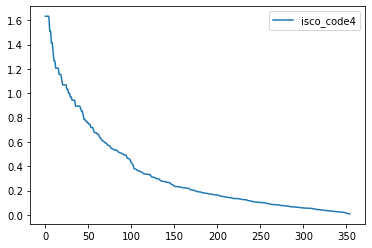

In [18]:
(2 / (0.5 * np.sqrt(df_pred["isco_code4"].value_counts().sort_values().reset_index().drop("index", axis=1)))).plot()

In [19]:
career_paths = df_pred.groupby("candidate_id")

In [20]:
candidate_lens = career_paths.apply(lambda x: len(x) - 1).to_dict()

In [21]:
num_classes = len(df_pred["isco_code4"].unique())
num_features = len(career_paths.mean().columns)
num_classes, num_features

(355, 9)

In [22]:
maximum_career_duration = 25

In [23]:
# Convert to 2d-arrays, grabbing the last 25 jobs of each candidate and getting rid of candidate_ids as values
career_paths = career_paths.progress_apply(lambda x: x.values[-(maximum_career_duration + 1):,1:])

100%|██████████| 469568/469568 [00:47<00:00, 9954.64it/s] 


In [24]:
# Drop careers that are only 1 job long
career_lens = career_paths.apply(len)
career_paths = career_paths.loc[(career_lens > 1)]

In [25]:
career_paths = career_paths.loc[career_paths.apply(lambda x: x[-1][-1] != x[-2][-1])]

In [26]:
career_paths.head()

candidate_id
84556    [[0.0, -0.292886688151019, -0.2104587010204839...
84612    [[0.0, 2.150219165944193, -0.3685852264755267,...
84731    [[0.0, -0.28409150707627623, -0.35066422025728...
85437    [[0.0, 0.4009553744120213, 0.3313881928721292,...
85888    [[0.0, -0.23816111701928622, -0.28952196374800...
dtype: object

In [27]:
idxs = []
x = []
y = []

# max_skills = len([col for col in df_pred if "skill_" in col])

for idx, career in zip(career_paths.index, career_paths.values):
    label = career[-1, -1]
    
    if not np.isnan(label):       
        idxs.append(idx)
        x.append(career[:-1].reshape(len(career) - 1, num_features))
        y.append(label)

idxs = np.array(idxs)
x = np.array(x)
y = np.array(y)

In [28]:
to_fill = np.zeros([len(x), len(max(x, key = lambda x: len(x))), num_features])

for i,j in enumerate(x):
    if len(j):
        to_fill[i][-len(j):] = j

In [29]:
max_len = len(max(x, key = lambda x: len(x)))
max_len

25

In [30]:
del df_pred
del x

In [31]:
# Filtered: (113428, 113428)
# Grouped: (176485, 176485)
len(to_fill), len(y)

(113724, 113724)

In [32]:
# to_fill = to_fill[:50000]
# y = y[:50000]

In [33]:
# Train test split
split = 0.8
random.seed(42)

training = np.array(random.sample(range(len(to_fill)), int(split * len(to_fill))))
test = np.array(list(set(range(len(to_fill))) - set(training)))

train_indices, val_indices = idxs[training], idxs[test]
X_train, X_val = to_fill[training], to_fill[test]
y_train, y_val = y[training].astype(int), y[test].astype(int)

In [54]:
# Class weights
counts = (np.bincount(y_train) + 1)
labels_weights = 1. / np.sqrt(counts)

weights = labels_weights[y_train]
sampler = WeightedRandomSampler(weights, len(weights))

# Create dataloaders
train_data = TensorDataset(torch.Tensor(train_indices), 
                           torch.Tensor(X_train), 
                           torch.Tensor(y_train).type(torch.LongTensor))

trainloader = DataLoader(train_data, batch_size=512, sampler=sampler)

val_data = TensorDataset(torch.Tensor(val_indices),
                         torch.Tensor(X_val),
                         torch.Tensor(y_val).type(torch.LongTensor))

valloader = DataLoader(val_data, batch_size=512, shuffle=True)

In [55]:
class eLSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, 
                 skills, certs, licenses, languages, addresses, 
                 w2v, candidate_lengths, max_len, 
                 skill_embedding_size=40, certs_embedding_size=15,
                 license_embedding_size=3, language_embedding_size=10,
                 address_embedding_size=25, function_embedding_size=40, 
                 isco4_embedding_size=20, education_embedding_size=3, 
                 isco_level_embedding_size=2, company_embedding_size=50):
        
        super(eLSTM, self).__init__()
              
        self.num_classes = num_classes
        self.input_size = input_size + 300
        self.hidden_size = hidden_size
        
        # Static embeddings: skills, certificates, licenses, languages
        self.skill_embedding = nn.Linear(317, skill_embedding_size, bias=False)
        self.skill_embedding.weight.data = torch.randn_like(self.skill_embedding.weight) 
        
        self.certs_embedding = nn.Linear(98, certs_embedding_size, bias=False)
        self.certs_embedding.weight.data = torch.randn_like(self.certs_embedding.weight) 
        
        self.license_embedding = nn.Linear(8, license_embedding_size, bias=False)
        self.license_embedding.weight.data = torch.randn_like(self.license_embedding.weight) 
        
        self.language_embedding = nn.Linear(23, language_embedding_size, bias=False)
        self.language_embedding.weight.data = torch.randn_like(self.language_embedding.weight) 
        
        # Address embedding
        self.address_embedding = nn.Embedding(4757, address_embedding_size)       
        
        # Categorical feature embeddings isco_functie_niveau	source	education	company_name	function_id	isco_code4
        self.function_embedding = nn.Embedding(2992, function_embedding_size)
        self.isco_code_embedding = nn.Embedding(num_classes, isco4_embedding_size)
        self.company_embedding = nn.Embedding(441153, company_embedding_size)
        self.source_embedding = nn.Embedding(2, 1)
        self.education_embedding = nn.Embedding(6, education_embedding_size)
        self.isco_level_embedding = nn.Embedding(5, isco_level_embedding_size)
                
        # -6 --> embedded features get replaced
        self.N = self.input_size - 5 + skill_embedding_size + certs_embedding_size + \
                 license_embedding_size + language_embedding_size + address_embedding_size + \
                 function_embedding_size + isco4_embedding_size + company_embedding_size + \
                 education_embedding_size + isco_level_embedding_size

        # layer_dim = 1
        layer_dim = num_layers
        gate_type = "tensor"
        qz_para_dim = 10
        
        self.encoder = GRUModel(hidden_size, self.N, layer_dim, gate_type, qz_para_dim).to(device)
        
        self.func = ODEfunc(self.N).to(device)
        
        self.step = max_len
        pre_step = 1
        per_vari_dim = int(hidden_size / self.N)
        temp_attention_type = 'temp_loc'
        vari_attention_type = 'vari_loc_all'

        self.att = attention2_mix(hidden_size, self.N, self.step, pre_step, per_vari_dim, temp_attention_type,
                                  vari_attention_type).to(device)
        
        self.fc = nn.Linear(self.N, num_classes)
        
        self.softmax = nn.LogSoftmax(dim=-1)

        # Skill lookup
        self.skills = skills
        
        # Certificate lookup
        self.certs = certs
        
        # License lookup
        self.licenses = licenses
        
        # Language lookup
        self.langs = languages
        
        # Address lookup
        self.adds = addresses
        
        # w2v lookup
        self.w2v_keys = set(w2v.keys())
        self.w2v = w2v
        
        # Career durations
        self.candidate_lengths = candidate_lengths
        self.max_len = max_len      
        
        def get_from_dict(x, cdict, N):
            return cdict.get(x, np.zeros((N,)))

        self.retrieve_static = np.vectorize(get_from_dict, otypes=[np.ndarray])
                
    def w2v_lookup(self, candidate, career_duration):
        """Finds a candidate's CVs and converts them to a tensor of length career_duration"""
            
        actual_career_duration = career_duration
        career_duration = min(career_duration, max_len)
            
        # Look for cvs
        if candidate.item() in self.w2v_keys:
            cvs = self.w2v[candidate.item()]
                
            storage = []

             # If a candidate only has one CV, proceed as normal
            if len(cvs.keys()) == 1:
                w2v_list = torch.LongTensor(cvs[0]).to(device)
                w2v_list = torch.stack([w2v_list] * career_duration)
            else: # Otherwise, stack them accordingly
                ks = np.array(list(cvs.keys()))
                
                to_skip = 0
                                
                # Make sure to use candidates' most recent max_len cvs
                if actual_career_duration > self.max_len:
                    # 0, 10, 20, 30, 40, 50
                    # duration = 50
                    # ---> 0, 5, 15, 25
                                        
                    # Update to only include most recent max_len
                    ks -= max_len
                    
                    # Drop everything older than max_len time steps
                    ks_2 = np.array([ks[i] for i in range(len(ks)) if i < len(ks) and (i + 1 >= len(ks) or ks[i + 1] > 0)])
                    
                    # Store how many we need to skip while indexing
                    to_skip = len(ks) - len(ks_2)
                    
                    # Update ks
                    ks = ks_2
                    ks[0] = 0
                    
                # Due to clipping, some careers are longer than max_len
                ks = np.array([k for k in ks if k <= min(self.max_len, career_duration)])

                # Find how many time steps (rows) each CV lasted
                durations = [ks[i+1] - ks[i]
                             if i < (len(ks) - 1) 
                             else career_duration - ks[i]
                             for i in range(len(ks))]

                embed_values = list(cvs.values())

                # When the CV got updated on the last timestep, aka our test value
                # Remove it from the list of durations, as it should be ignored
                if durations[-1] == 0: 
                    durations.pop()

                # Create Tensor(s)
                if durations:
                    for i, duration in enumerate(durations):
                        # Figure out negative duration cause
                        storage.append(torch.stack([torch.Tensor(embed_values[i + to_skip])] * duration, dim=0))
                else:
                    w2v_list = torch.LongTensor(cvs[0]).to(device)

                # Combine stored tensors into a single tensor
                w2v_list = torch.cat((storage)).type(torch.LongTensor).to(device)
        else:
            w2v_list = torch.LongTensor([0] * 300).to(device)
            w2v_list = torch.stack([w2v_list] * career_duration)

        return w2v_list        
 
    def forward(self, candidate, x):               
        # Default width of a row (filled with 0s)
        feature_width = torch.Tensor([0] * 393).type(torch.LongTensor).to(device)
        
        candidate_features = []
        
        skill_list = self.retrieve_static(candidate, self.skills, 317)
        skill_list = torch.LongTensor(np.stack(skill_list)).to(device)
        
        certs_list = self.retrieve_static(candidate, self.certs, 98)
        certs_list = torch.LongTensor(np.stack(certs_list)).to(device)
        
        license_list = self.retrieve_static(candidate, self.licenses, 8)
        license_list = torch.LongTensor(np.stack(license_list)).to(device)
        
        langs_list = self.retrieve_static(candidate, self.langs, 23)
        langs_list = torch.LongTensor(np.stack(langs_list)).to(device)
            
        address = self.retrieve_static(candidate, self.adds, 1)
        address = torch.LongTensor(np.stack(address)).to(device)
        
        # Embed every static feature
        skill_list, certs_list, license_list, langs_list = [self.skill_embedding(skill_list.type(torch.FloatTensor).to(device)),
                                                            self.certs_embedding(certs_list.type(torch.FloatTensor).to(device)),
                                                            self.license_embedding(license_list.type(torch.FloatTensor).to(device)),
                                                            self.language_embedding(langs_list.type(torch.FloatTensor).to(device))]
        
        # Combine and embed
        batch_features = torch.cat([skill_list, certs_list, 
                                    license_list, langs_list], dim=-1).type(torch.FloatTensor).to(device)
            
        batch_addresses = self.address_embedding(address)[:,0,:]
                
        # For each candidate in the current batch
        for i, c in enumerate(candidate):
            # Get career duration
            career_duration = self.candidate_lengths[c.item()]
                        
            # Get CV embeddings
            w2v_list = self.w2v_lookup(c, career_duration)
            
            # Reset to max_len
            career_duration = min(career_duration, max_len)

            # Only create zeros if needed (e.g. less than max_len career duration)
            if (self.max_len - career_duration) > 0:
                zeros = torch.stack([feature_width] * (self.max_len - career_duration))
            else: # Reset zeros to prevent shape mismatch
                zeros = torch.LongTensor([]).to(device)
                   
            # Broadcast and add static features
            static_features = torch.stack([batch_features[i]] * career_duration).type(torch.LongTensor).to(device)
            address_emb = torch.stack([batch_addresses[i]] * career_duration).type(torch.LongTensor).to(device)
            
            # Combine w2v, static features, and address
            full_features = torch.cat([w2v_list, static_features, address_emb], dim=1)
                                    
            # Broadcast CV, static, and address to the correct length
            full_features = torch.cat([zeros, full_features], dim=0)
                    
            # Store result
            candidate_features.append(full_features)
                                
        # Convert list of tensors to actual tensor
        additional_features = torch.stack((candidate_features)).type(torch.FloatTensor).to(device)
                
        # isco_functie_niveau, education, function_id, isco_code4
        isco_level, source, education, company_name, function_id, isco_code = [x[:,:,-6],
                                                                               x[:,:,-5],
                                                                               x[:,:,-4],
                                                                               x[:,:,-3],
                                                                               x[:,:,-2],
                                                                               x[:,:,-1]]
        
        x = x[:,:,:-6].to(device)
        
        isco_level_smoothing = (isco_level != 0).unsqueeze(-1)
        source_smoothing = (source != 0).unsqueeze(-1)
        education_smoothing = (education != 0).unsqueeze(-1)
        company_name_smoothing = (company_name != 0).unsqueeze(-1)
        function_id_smoothing = (function_id != 0).unsqueeze(-1)
        isco_code_smoothing = (isco_code != 0).unsqueeze(-1)
        
        isco_level, source, education, company_name, function_id, isco_code  = [self.isco_level_embedding(isco_level.type(torch.LongTensor).to(device)) * isco_level_smoothing,
                                                                                self.source_embedding(source.type(torch.LongTensor).to(device)) * source_smoothing,
                                                                                self.education_embedding(education.type(torch.LongTensor).to(device)) * education_smoothing,
                                                                                self.company_embedding(company_name.type(torch.LongTensor).to(device)) * company_name_smoothing,
                                                                                self.function_embedding(function_id.type(torch.LongTensor).to(device)) * function_id_smoothing,
                                                                                self.isco_code_embedding(isco_code.type(torch.LongTensor).to(device)) * isco_code_smoothing]        
                
        # Add features
        x = torch.cat([x, isco_level, source, education, company_name, function_id, isco_code, additional_features], dim=2)
        x = Variable(x.view(-1, self.step, self.N).to(device))
        
        # change oder of attention and ode part
        h, _, _ = self.encoder(x)
                
        att_h_input = torch.stack(h, dim=1)
        
        c_t, qz_para, temp_weight, vari_weight = self.att(att_h_input)
        
        qz0_mean, qz0_logvar = qz_para[:, :self.N], qz_para[:, self.N:]
        
        epsilon = torch.randn(qz0_mean.size()).to(device)
        
        z0 = epsilon * torch.exp(0.5 * qz0_logvar) + qz0_mean
        
        # forward in time and solve ode for reconstructions
        
        total_T = torch.Tensor([1])
        pred_z = odeint(self.func, z0, total_T).permute(1, 0, 2)        
        pred_y = self.fc(pred_z).squeeze(1)
        
        pred_y = self.softmax(pred_y)
        
        return pred_y, temp_weight, vari_weight

In [56]:
def train_loop(model, trainloader, valloader, optimizer, scheduler, criterion, num_epochs):

    results = defaultdict(list)
    
    passed = [0]
    training_losses = [6]
    test_losses = [6]
    accuracy = [0]
    
    # Train the model
    for epoch in range(num_epochs):
        start = time.time()
        print("-------------------------------------------------------------------------------")
        print(f"Epoch starting at: {datetime.now().strftime('%H:%M:%S')}")
        
        training_loss = 0
        
        for i, (candidate, career, job) in enumerate(trainloader):
            career, job = career.to(device), job.to(device)
            optimizer.zero_grad()

            outputs, temp_weight, vari_weight = model(candidate, career)
                        
            # obtain the loss function
            loss = criterion(outputs, job)
            loss = loss.mean()           
            loss.backward()
            optimizer.step()
            
            training_loss += loss.item()
            
            print("Epoch: %d, batch: %d/%d, loss: %1.5f" % (epoch + 1, i + 1, len(trainloader), loss.item()), end="\r")
                    
        training_loss /= len(trainloader)
               
        stats = test_loop(valloader, model, criterion)
        
        done = int(time.time() - start)        
        print(f"Epoch duration: {int((done) // 60)}:{int((done) % 60):02d}")

        results["Epoch"].append(epoch + 1)
        results["Acc@1"].append(stats[0])
        results["Acc@5"].append(stats[1])
        results["Acc@10"].append(stats[2])
        results["Acc@20"].append(stats[3])
        results["test_loss"].append(stats[4])
        results["training_loss"].append(training_loss)
        results["duration"].append(done)
        
        scheduler.step()
                
        passed.append(epoch + 1)
        training_losses.append(training_loss)
        test_losses.append(stats[4])
        accuracy.append(stats[0])
        
        plt.plot(passed, training_losses, label="Training Loss")
        plt.plot(passed, test_losses, label="Test Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Average loss")
        plt.legend()
        plt.show()
                        
    return results
        
def test_loop(dataloader, model, criterion):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, acc1, acc5, acc10, acc20 = 0, 0, 0, 0, 0
    
    with torch.no_grad():
        for candidate, career, job in dataloader:
            career, job = career.to(device), job.to(device)
            pred, temp_weight, vari_weight = model(candidate, career)
            
            test_loss += criterion(pred, job).mean().item()
            acc1 += (pred.argmax(1) == job).type(torch.float).sum().item()
            
            sorted_preds = torch.argsort(pred, 1, descending=True)
            
            at5 = []
            at10 = []
            at20 = []
            
            for answer, predictions in zip(job, sorted_preds):
                at5.append(answer.item() in predictions[:5])
                at10.append(answer.item() in predictions[:10])
                at20.append(answer.item() in predictions[:20])
            
            acc5 += np.sum(at5)
            acc10 += np.sum(at10)
            acc20 += np.sum(at20)
            
    test_loss /= num_batches
    acc1 /= size
    acc5 /= size
    acc10 /= size
    acc20 /= size
    print(f"\nTest Error:")
    print(f"Acc@1: {(100*acc1):>0.2f}%, Acc@5: {100*acc5:>0.2f}%, " +\
          f"Acc@10: {100*acc10:>0.2f}%, Acc@20: {100*acc20:>0.2f}% Avg loss: {test_loss:>8f}")
    
    return acc1, acc5, acc10, acc20, test_loss

In [57]:
torch.cuda.empty_cache()

Current iteration 0/15
- Initial learning rate: 0.01
- Model: 

 eLSTM(
  (skill_embedding): Linear(in_features=317, out_features=40, bias=False)
  (certs_embedding): Linear(in_features=98, out_features=15, bias=False)
  (license_embedding): Linear(in_features=8, out_features=3, bias=False)
  (language_embedding): Linear(in_features=23, out_features=10, bias=False)
  (address_embedding): Embedding(4757, 25)
  (function_embedding): Embedding(2992, 40)
  (isco_code_embedding): Embedding(355, 20)
  (company_embedding): Embedding(441153, 50)
  (source_embedding): Embedding(2, 1)
  (education_embedding): Embedding(6, 3)
  (isco_level_embedding): Embedding(5, 2)
  (encoder): GRUModel(
    (gru_cell): GRUCell()
    (fc_q): Linear(in_features=512, out_features=1024, bias=True)
  )
  (func): ODEfunc(
    (lin_hh): Linear(in_features=512, out_features=512, bias=False)
    (lin_hz): Linear(in_features=512, out_features=512, bias=False)
    (lin_hr): Linear(in_features=512, out_features=512, bias=

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch: 1, batch: 178/178, loss: 5.35177
Test Error:
Acc@1: 10.40%, Acc@5: 34.90%, Acc@10: 48.44%, Acc@20: 61.41% Avg loss: 4.446771
Epoch duration: 3:58


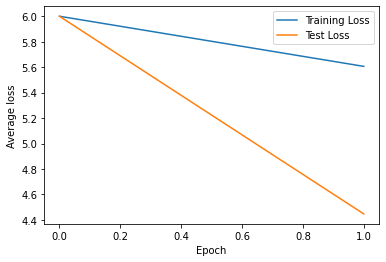

-------------------------------------------------------------------------------
Epoch starting at: 21:54:57
Epoch: 2, batch: 178/178, loss: 5.41382
Test Error:
Acc@1: 11.53%, Acc@5: 37.80%, Acc@10: 51.08%, Acc@20: 63.37% Avg loss: 4.441933
Epoch duration: 3:59


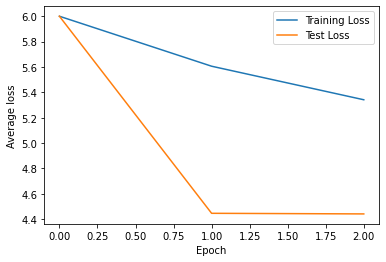

-------------------------------------------------------------------------------
Epoch starting at: 21:58:57
Epoch: 3, batch: 178/178, loss: 5.25140
Test Error:
Acc@1: 12.53%, Acc@5: 40.50%, Acc@10: 52.52%, Acc@20: 65.89% Avg loss: 4.362638
Epoch duration: 3:59


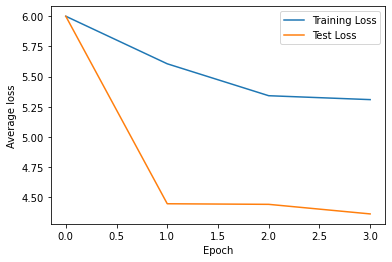

In [58]:
device = ("cuda:0" if torch.cuda.is_available() else "cpu")

num_epochs = 3
current = 0

criterion = torch.nn.CrossEntropyLoss()

full_results = []

# TODO: GRU vs. LSTM
learning_rates = [1e-2, 1e-3, 1e-4]
hidden_sizes = [512, 1024, 2048, 4096, 8192]
num_layers = [1, 2, 3][:2]

try:            
    for learning_rate in learning_rates:
        for num_layer in num_layers:
            for hidden_size in hidden_sizes:

                lstm = eLSTM(num_classes=num_classes,
                             input_size=num_features,
                             hidden_size=hidden_size,
                             skills=skills, 
                             certs=certs,
                             licenses=licenses,
                             languages=languages,
                             addresses=addresses,
                             w2v=w2v,
                             address_embedding_size=25,
                             candidate_lengths=candidate_lens,
                             max_len=max_len)

                lstm = lstm.to(device)

                optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
                scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

                if current >= 1:
                    print("\n\n\n")

                print(f"Current iteration {current}/{len(learning_rates) * len(hidden_sizes)}")
                print(f"- Initial learning rate: {learning_rate}\n- Model: \n\n", lstm, "\n")

                # Store results of current configuration
                outcome = train_loop(lstm, trainloader, valloader, optimizer, scheduler, criterion, num_epochs)
                outcome["lr"] = [learning_rate] * num_epochs
                outcome["Nodes per layer"] = [hidden_size] * num_epochs

                full_results.append(outcome)

                current += 1

                break
            break
        break
except KeyboardInterrupt:
    pass

In [59]:
merge_results = defaultdict(list)

for res in full_results:
    for k, v in res.items():
        merge_results[k].extend(v)
        
total = pd.DataFrame(merge_results).set_index(["lr", "Nodes per layer", "Epoch"])

In [60]:
total

Acc@1     Acc@5    Acc@10    Acc@20  test_loss  \
lr   Nodes per layer Epoch                                                      
0.01 512             1      0.103979  0.349044  0.484414  0.614069   4.446771   
                     2      0.115278  0.377973  0.510794  0.633678   4.441933   
                     3      0.125258  0.404968  0.525214  0.658914   4.362638   

                            training_loss  duration  
lr   Nodes per layer Epoch                           
0.01 512             1           5.606136       238  
                     2           5.341734       239  
                     3           5.309373       239

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Batch accuracy: 0.130859375

Previous-job baseline accuracy: 0.0
Majority class accuracy: 0.1328125

Fraction of previous job predictions: 0.1328125
Majority class predictions: 0.615234375


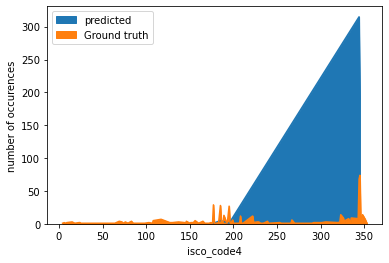

In [61]:
with torch.no_grad():
    for candidate, career, job in valloader:
        career, job = career.to(device), job.to(device)
        pred, temp_weight, vari_weight = lstm(candidate, career)
        
        print("Batch accuracy:", (pred.argmax(1) == job).type(torch.float).mean().item())        
        print()
        
        # Check how often the model predicted the previous job + compare to baseline performance
        previous_job = torch.Tensor(career_paths.loc[candidate.cpu()].apply(lambda x: x[-2][-1]).values).to(device)
        print("Previous-job baseline accuracy:", (job == previous_job).cpu().numpy().mean())
        print("Majority class accuracy:", (job == majority_class).cpu().numpy().mean())
        print()
        
        print("Fraction of previous job predictions:", (pred.argmax(1) == previous_job).cpu().numpy().mean())
        print("Majority class predictions:", (pred.argmax(1) == majority_class).cpu().numpy().mean())
        
        b = pd.Series(Counter(pred.argmax(1).tolist()))
        b.sort_index().plot(kind="area", label="predicted")
    
        a = pd.Series(Counter(job.tolist()))
        a.sort_index().plot(kind="area", label="Ground truth")
        
        
        plt.xlabel("isco_code4")
        plt.ylabel("number of occurences")
        plt.legend()        
        plt.show()        
        
        break

In [62]:
# x, isco_level, source, education, company_name, function_id, isco_code, w2v_list, skill_list, certs_list, license_list, langs_list, address_emb
feature_names = ["Time spent", "Time between", "isco level", "source",
                 "education", "company name", "function", "isco code",
                 "cv", "skills", "certificates", "licenses", "languages", "location"]

skill_embedding_size=40
certs_embedding_size=15
license_embedding_size=3
language_embedding_size=10
address_embedding_size=25
function_embedding_size=40 
isco4_embedding_size=20
education_embedding_size=3 
isco_level_embedding_size=2
company_embedding_size=50
source_embedding_size = 1
w2v_embedding_size = 300

embedding_sizes= [0, 1, 2, isco_level_embedding_size, source_embedding_size,
                  education_embedding_size, company_embedding_size, function_embedding_size, 
                  isco4_embedding_size, w2v_embedding_size, skill_embedding_size, certs_embedding_size, 
                  license_embedding_size, language_embedding_size, address_embedding_size]

In [63]:
def merge_layers(output, embedding_sizes):
    """order: start=0, reg_features, isco_level_embedding_size, source_embedding_size, 
              education_embedding_size, company_embedding_size, function_embedding_size, 
              isco4_embedding_size, w2v_embedding_size, skill_embedding_size, 
              certs_embedding_size, license_embedding_size, language_embedding_size, 
              address_embedding_size"""
    
    idxs = np.cumsum(embedding_sizes)
        
    result = np.stack([output[idxs[i]:idxs[i+1]].mean(axis=0) for i in range(len(idxs) - 1)])
    
    return result

<AxesSubplot:>

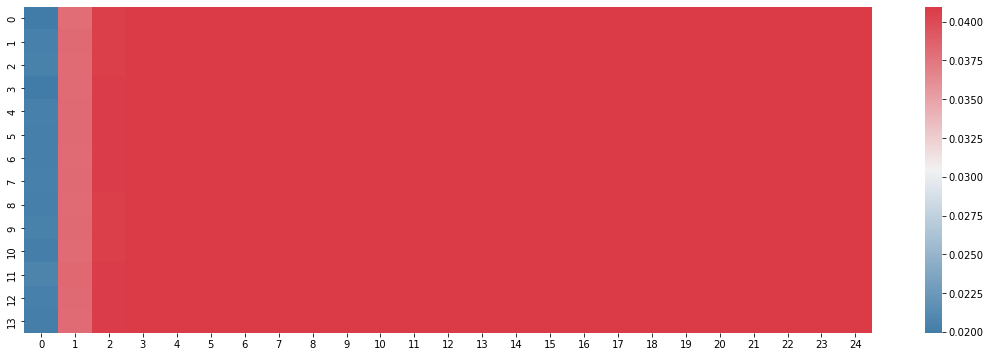

In [64]:
plt.figure(figsize=(19, 6))

cmap=sns.diverging_palette(240, 10, n=9, as_cmap=True)
sns.heatmap(merge_layers(temp_weight.mean(0).cpu(), embedding_sizes), cmap=cmap)

In [68]:
vari_weight.shape

torch.Size([512, 512, 1])